# 0. Install Dependencies and Bring in Data

In [4]:
!pip install pandas tensorflow numpy 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv('/kaggle/input/d/ferchichiakrem/training/train.csv')

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
import re
# function to clean the text performin some simple regex pattern matching
def apply_regex(corpus):
    corpus = corpus.apply(lambda x: re.sub("\S*\d\S*"," ", x))          # removes numbers and words concatenated with numbers (IE h4ck3r)
    corpus = corpus.apply(lambda x: re.sub("\S*@\S*\s?"," ", x))        # removes emails and mentions (words with @)
    corpus = corpus.apply(lambda x: re.sub("\S*#\S*\s?"," ", x))        # removes hashtags (words with #)
    corpus = corpus.apply(lambda x: re.sub(r'http\S+', ' ', x))         # removes URLs
    corpus = corpus.apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ',x))    # keeps numbers and letters
    corpus = corpus.apply(lambda x: x.replace(u'\ufffd', '8'))          # replaces the ASCII '�' symbol with '8'
    corpus = corpus.apply(lambda x: re.sub(' +', ' ', x))               # removes multiple spaces
    return corpus
# apply the function and clean the data
df['comment_text'] = apply_regex(df['comment_text'])

# 1. Preprocess

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [10]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [11]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [12]:
MAX_FEATURES = 200000 # number of words in the vocab


In [13]:
#TextVectorization:transforms raw text into numerical sequences

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,#the vectorizer will keep the top 200000 most frequent words in the dataset
                               output_sequence_length=1800,#number of tokens in each sequence
                               output_mode='int')#Outputs sequences of integer indices

In [14]:
#build the vocabulary and prepare the TextVectorization layer for processing data.
vectorizer.adapt(X.values)

In [15]:
#vectorizer(X.values) transforms X.values into integer-encoded sequences,Each word in the text is replaced with its corresponding index from the vocabulary .
vectorized_text = vectorizer(X.values)# tensor of integer sequences


In [16]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [17]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

SyntaxError: incomplete input (<ipython-input-18-f5087f9514e3>, line 52)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf

# Define parameters
embedding_size = 128  # Embedding dimensions
max_features = 200000  # Vocabulary size (MAX_FEATURES)
input_length = 1800  # Sequence length (as defined in TextVectorization)

# Build the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_size, 
                    input_length=input_length))

# LSTM layer
model.add(LSTM(20, return_sequences=True, name='lstm_layer'))

# Pooling layer
model.add(GlobalMaxPool1D())

# Dropout and dense layers with regularization
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(6, activation='sigmoid'))

# Explicitly build the model
model.build(input_shape=(None, input_length))  # Batch size is dynamic

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train,
                    epochs=2,
                    validation_data=val)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1800, 128)           │      25,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 1800, 20)            │          11,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 20)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,612,196 (97.70 MB)

 Trainable params: 25,612,196 (97.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 366s 52ms/step - accuracy: 0.8565 - loss: 0.1026 - val_accuracy: 0.9943 - val_loss: 0.0456
Epoch 2/2
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 360s 52ms/step - accuracy: 0.9925 - loss: 0.0476 - val_accuracy: 0.9949 - val_loss: 0.0384
997/997 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9938 - loss: 0.0397
Test Accuracy: 0.9945


This model is a **sequential deep learning** model designed for text classification or multi-label classification, which makes use of an embedding layer, an LSTM layer for sequential data processing, and fully connected dense layers for further feature extraction and decision-making.

In [20]:
# Save the model after training
model.save('trained_model.h5')

print("Model saved as 'trained_model.h5'")


Model saved as 'trained_model.h5'


In [21]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('trained_model.h5')


In [22]:
history

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

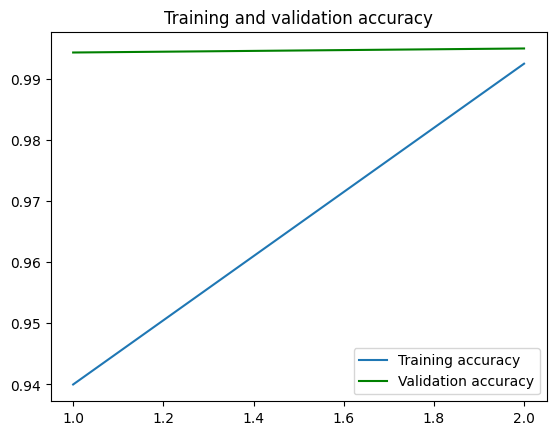

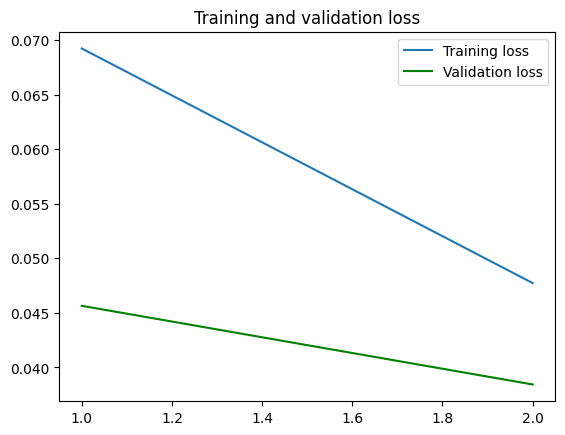

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3. Make Predictions

In [25]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [26]:
input_text = tf.expand_dims(input_text, axis=0)

In [27]:
res = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


In [28]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [29]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [30]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
res.shape

(1, 6)

# 4. Evaluate Model

In [32]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [33]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Load the saved model
model_path = "/kaggle/working/trained_model.h5"
model = load_model(model_path)

# Evaluate on the `test` dataset
results = model.evaluate(test, verbose=1)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")

# Compute additional metrics manually
y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X_test, y_test = batch
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Apply threshold for binary predictions

    # Append true labels and predictions for metric computation
    y_true_list.extend(y_test.flatten())
    y_pred_list.extend(y_pred.flatten())

# Convert to arrays
y_true_list = tf.convert_to_tensor(y_true_list)
y_pred_list = tf.convert_to_tensor(y_pred_list)

# Calculate additional metrics
precision = precision_score(y_true_list, y_pred_list)
recall = recall_score(y_true_list, y_pred_list)
accuracy = accuracy_score(y_true_list, y_pred_list)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")


997/997 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9945 - loss: 0.0395
Test Loss: 0.0392, Test Accuracy: 0.9942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━

# 5. Test and Gradio

In [34]:
!pip install gradio jinja2

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.5/450.5 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 95.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: hugging

In [35]:
import tensorflow as tf
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('/kaggle/working/trained_model.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

In [ ]:
res

In [38]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [39]:
interface = gr.Interface(
    fn=score_comment,  # Function to score comments
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),  # Input component
    outputs=gr.Textbox(label="Score")  # Output component
)

In [ ]:
#interface = gr.Interface(fn=score_comment,
                      #  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                       # outputs='text')

In [40]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://796e5351b274b3c34a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [42]:
!pip install Groq


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 5.2 MB/s eta 0:00:00


In [46]:
import os
from groq import Groq
import tensorflow as tf  # Assuming TensorFlow is used for toxicity detection

# Initialize the Groq client
client = Groq(
    api_key='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'
)

# Load your trained toxicity detection model
model = tf.keras.models.load_model('/kaggle/working/trained_model.h5')

def is_toxic(comment):
    """
    Detect whether the comment is toxic.
    Returns True if toxic, False otherwise.
    """
   
    comment_tensor = tf.convert_to_tensor([comment])
    # Preprocess the comment (e.g., tokenization, padding) to match the model's input
    preprocessed_comment = vectorizer(comment)  # Implement this function
    prediction = model.predict(np.expand_dims(preprocessed_comment,0))
    #prediction = model.predict(preprocessed_comment)
    prediction_scalar = prediction[0][0]  # Get the first element as a scalar
    return prediction_scalar > 0.5
def correct_toxic_comment(comment):
    """
    Use LLM to correct toxic comments.
    """
    messages = [
        {"role": "system", "content": "You are an assistant specializing in improving comment quality."},
        {"role": "user", "content": f"The following comment is toxic: {comment}. Please rewrite it to remove toxicity."}
    ]
    
    chat_completion = client.chat.completions.create(
        messages=messages,
        model="llama3-8b-8192"
    )
    
    return chat_completion.choices[0].message.content

def llm_answer(comment):
    """
    Main function to handle the comment:
    - Check if it's toxic.
    - If toxic, correct it.
    - If non-toxic, return a suitable message.
    """
    if is_toxic(comment):
        corrected_comment = correct_toxic_comment(comment)
        return f"The comment was toxic and has been corrected: {corrected_comment}"
    else:
        return "The comment is non-toxic and does not require any changes."

# Example usage

comment = "hello apes"
response = llm_answer(comment)
print(response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
The comment is non-toxic and does not require any changes.
